<a href="https://colab.research.google.com/github/PravalikaMuthoju/INTERNSHIP-PROJECTS/blob/main/Green_Hydrogen1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the path to your dataset CSV file: /content/synthetic_green_hydrogen_dataset.zip
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Random Forest Results:
MAE: 0.4832
MSE: 0.3656
R² Score: 0.9031

MLP Regressor Results:
MAE: 0.6324
MSE: 0.6490
R² Score: 0.8280

SVR Results:
MAE: 0.4615
MSE: 0.3344
R² Score: 0.9114

LSTM-CNN Results:
MAE: 0.7024
MSE: 0.8059
R² Score: 0.7929


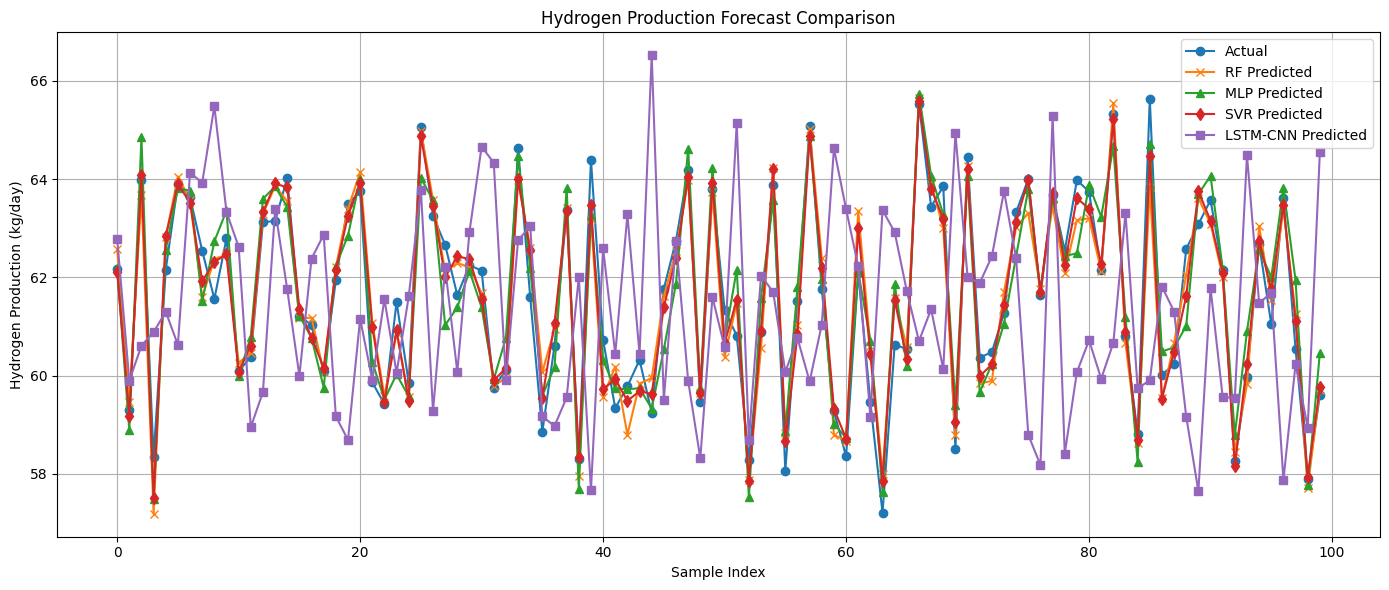


--- SARIMAX Model ---

SARIMAX Results:
MAE: 0.6328
MSE: 0.5981
R² Score: 0.8463

--- SHAP Feature Importance for Random Forest ---


100%|===================| 656/658 [00:26<00:00]       

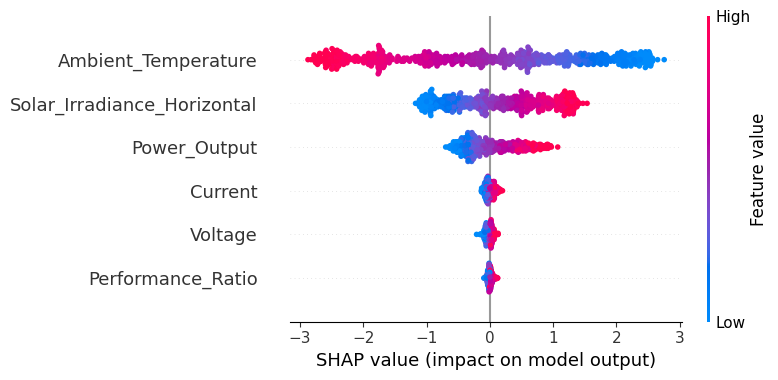

In [ ]:
# ✅ Corrected and Complete Code for Hydrogen Forecasting with All Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Load dataset ---
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# --- Required columns ---
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# --- Feature and target ---
X = df[required_columns[:-1]]
y = df['Daily_Hydrogen_Production']

# --- Scaling ---
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- MLP ---
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                         solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# --- SVR ---
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# --- LSTM-CNN ---
X_lstm = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train_lstm, X_test_lstm = X_lstm[:len(X_train)], X_lstm[len(X_train):]
y_train_lstm, y_test_lstm = y_scaled[:len(X_train)], y_scaled[len(X_train):]

lstm_model = Sequential()
lstm_model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(MaxPooling1D(2))
lstm_model.add(Flatten())
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# --- Evaluation function ---
def evaluate_model(name, y_true_scaled, y_pred_scaled):
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = target_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    print(f"\n{name} Results:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    return y_true, y_pred

# --- Evaluate All Models ---
y_test_rf, y_pred_rf = evaluate_model("Random Forest", y_test, rf_model.predict(X_test))
y_test_mlp, y_pred_mlp = evaluate_model("MLP Regressor", y_test, mlp_model.predict(X_test))
y_test_svr, y_pred_svr = evaluate_model("SVR", y_test, svr_model.predict(X_test))
y_test_lstm, y_pred_lstm = evaluate_model("LSTM-CNN", y_test_lstm, y_pred_lstm)

# --- Plot Predictions ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_rf[:100], label='Actual', marker='o')
plt.plot(y_pred_rf[:100], label='RF Predicted', marker='x')
plt.plot(y_pred_mlp[:100], label='MLP Predicted', marker='^')
plt.plot(y_pred_svr[:100], label='SVR Predicted', marker='d')
plt.plot(y_pred_lstm[:100], label='LSTM-CNN Predicted', marker='s')
plt.title('Hydrogen Production Forecast Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SARIMAX ---
print("\n--- SARIMAX Model ---")
df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
df.set_index('Date', inplace=True)
target_series = df['Daily_Hydrogen_Production']
exog_series = df[required_columns[:-1]]
train_size = int(0.8 * len(df))

sarimax_model = SARIMAX(target_series[:train_size], exog=exog_series[:train_size], order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_result = sarimax_model.fit(disp=False)
y_pred_sarimax = sarimax_result.predict(start=train_size, end=len(df)-1, exog=exog_series[train_size:])
y_test_sarimax = target_series[train_size:].values

print("\nSARIMAX Results:")
print(f"MAE: {mean_absolute_error(y_test_sarimax, y_pred_sarimax):.4f}")
print(f"MSE: {mean_squared_error(y_test_sarimax, y_pred_sarimax):.4f}")
print(f"R² Score: {r2_score(y_test_sarimax, y_pred_sarimax):.4f}")

# --- SHAP Summary Plot (Random Forest) ---
print("\n--- SHAP Feature Importance for Random Forest ---")
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=required_columns[:-1])


Enter the path to your dataset CSV file: /content/synthetic_green_hydrogen_dataset.zip
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Random Forest Results:
MAE: 0.4832
MSE: 0.3656
R² Score: 0.9031

MLP Regressor Results:
MAE: 0.6324
MSE: 0.6490
R² Score: 0.8280

SVR Results:
MAE: 0.4615
MSE: 0.3344
R² Score: 0.9114

LSTM-CNN Results:
MAE: 0.7484
MSE: 0.8849
R² Score: 0.7726


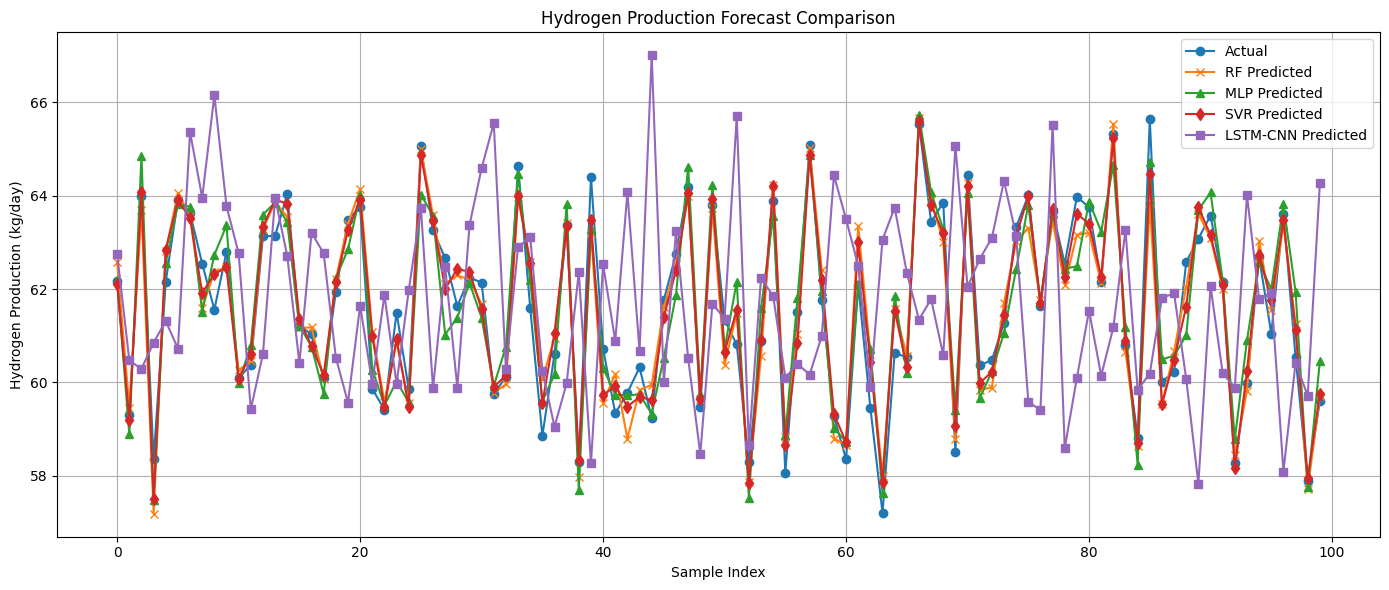


--- SARIMAX Model ---

SARIMAX Results:
MAE: 0.6328
MSE: 0.5981
R² Score: 0.8463

--- SHAP Feature Importance for Random Forest ---


100%|===================| 656/658 [00:26<00:00]       

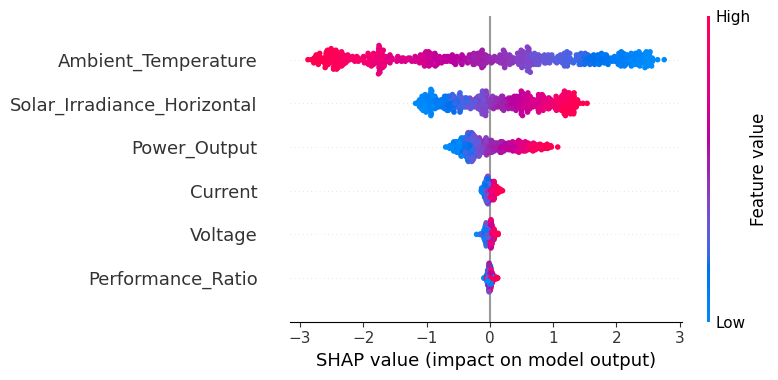

In [ ]:
# Full Hydrogen Forecasting with All Models: RF, MLP, LSTM-CNN, SVR, SARIMAX, SHAP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load dataset
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Required columns
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Feature and target
X = df[required_columns[:-1]]
y = df['Daily_Hydrogen_Production']

# Scale data
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# LSTM-CNN
X_lstm = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train_lstm, X_test_lstm = X_lstm[:len(X_train)], X_lstm[len(X_train):]
y_train_lstm, y_test_lstm = y_scaled[:len(X_train)], y_scaled[len(X_train):]

lstm_model = Sequential()
lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Flatten())
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluation

def evaluate_model(name, y_true_scaled, y_pred_scaled):
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = target_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    print(f"\n{name} Results:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    return y_true, y_pred

# Predictions & evaluation
y_test_rf, y_pred_rf = evaluate_model("Random Forest", y_test, rf_model.predict(X_test))
y_test_mlp, y_pred_mlp = evaluate_model("MLP Regressor", y_test, mlp_model.predict(X_test))
y_test_svr, y_pred_svr = evaluate_model("SVR", y_test, svr_model.predict(X_test))
y_test_lstm, y_pred_lstm = evaluate_model("LSTM-CNN", y_test_lstm, y_pred_lstm)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_rf[:100], label='Actual', marker='o')
plt.plot(y_pred_rf[:100], label='RF Predicted', marker='x')
plt.plot(y_pred_mlp[:100], label='MLP Predicted', marker='^')
plt.plot(y_pred_svr[:100], label='SVR Predicted', marker='d')
plt.plot(y_pred_lstm[:100], label='LSTM-CNN Predicted', marker='s')
plt.title('Hydrogen Production Forecast Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SARIMAX
print("\n--- SARIMAX Model ---")
df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
df.set_index('Date', inplace=True)
target_series = df['Daily_Hydrogen_Production']
exog_series = df[required_columns[:-1]]
train_size = int(0.8 * len(df))

sarimax_model = SARIMAX(target_series[:train_size], exog=exog_series[:train_size], order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_result = sarimax_model.fit(disp=False)
y_pred_sarimax = sarimax_result.predict(start=train_size, end=len(df)-1, exog=exog_series[train_size:])
y_test_sarimax = target_series[train_size:].values

print("\nSARIMAX Results:")
print(f"MAE: {mean_absolute_error(y_test_sarimax, y_pred_sarimax):.4f}")
print(f"MSE: {mean_squared_error(y_test_sarimax, y_pred_sarimax):.4f}")
print(f"R² Score: {r2_score(y_test_sarimax, y_pred_sarimax):.4f}")

# SHAP Summary Plot
print("\n--- SHAP Feature Importance for Random Forest ---")
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=required_columns[:-1])


RAN FOREST & MLP

Enter the path to your dataset CSV file: /content/synthetic_green_hydrogen_dataset.zip
Random Forest Results:
MAE: 0.4832
MSE: 0.3656
R² Score: 0.9031

MLP Regressor Results:
MAE: 0.6324
MSE: 0.6490
R² Score: 0.8280



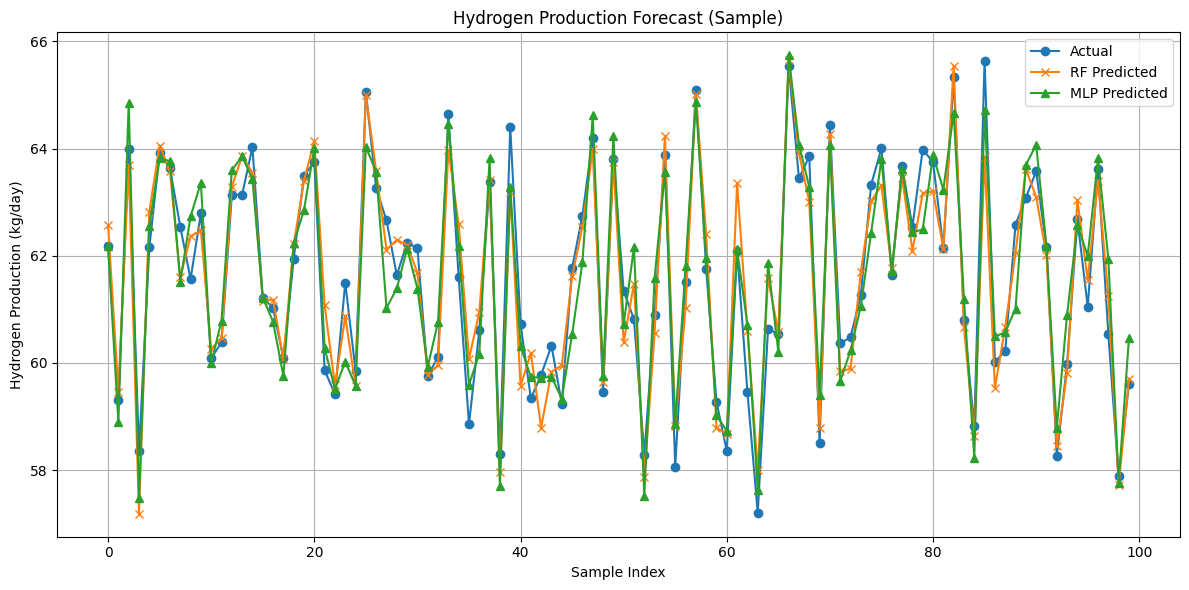

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Load the dataset manually (user will upload their own file)
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Step 2: Verify required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features]
y = df[target]

# Step 4: Normalize features and target
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Step 5: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Step 6: Train models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Step 7: Evaluation function
def evaluate_model(name, model):
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)
    r2 = r2_score(y_test_orig, y_pred)
    print(f"{name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}\n")
    return y_test_orig, y_pred

# Step 8: Evaluate both models
y_test_rf, y_pred_rf = evaluate_model("Random Forest", rf_model)
y_test_mlp, y_pred_mlp = evaluate_model("MLP Regressor", mlp_model)

# Step 9: Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test_rf[:100], label='Actual', marker='o')
plt.plot(y_pred_rf[:100], label='RF Predicted', marker='x')
plt.plot(y_pred_mlp[:100], label='MLP Predicted', marker='^')
plt.title('Hydrogen Production Forecast (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Q-LEARNING

Enter the path to your dataset CSV file: /content/synthetic_green_hydrogen_dataset.zip
Reinforcement Learning (Q-Learning Agent) Results:
MAE: 0.2519
MSE: 0.0843
R² Score: 0.9779



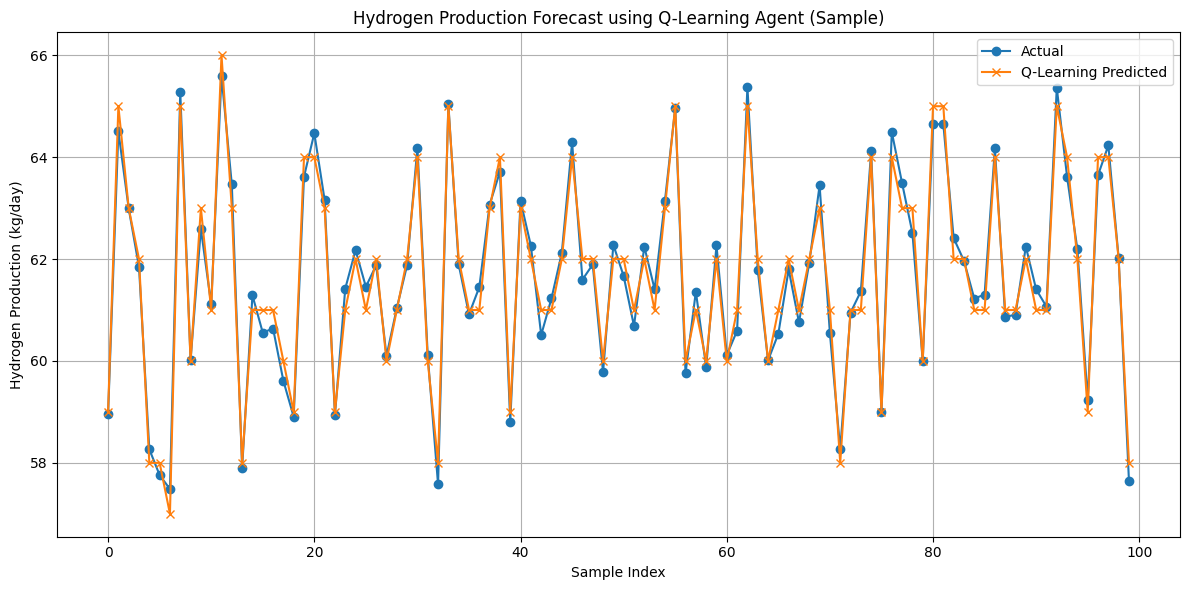

In [ ]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset manually
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Step 2: Verify required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize features and target
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define a Q-learning compatible environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # Discretized hydrogen predictions: 56 to 67 kg/day
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Step 6: Initialize Q-table
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))

# Step 7: Q-learning parameters
episodes = 1000  # Single pass through dataset
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

# Step 8: Q-learning loop
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action] if not done else reward
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state

# Step 9: Use Q-table to generate predictions
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Step 10: Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("Reinforcement Learning (Q-Learning Agent) Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Step 11: Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Q-Learning Predicted', marker='x')
plt.title('Hydrogen Production Forecast using Q-Learning Agent (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Q-learning training...
Episode 100/100 - Total Reward: -23168.38

Q-Learning Results:
MAE: 62.4558
MSE: 3918.6227
R² Score: -390.7304



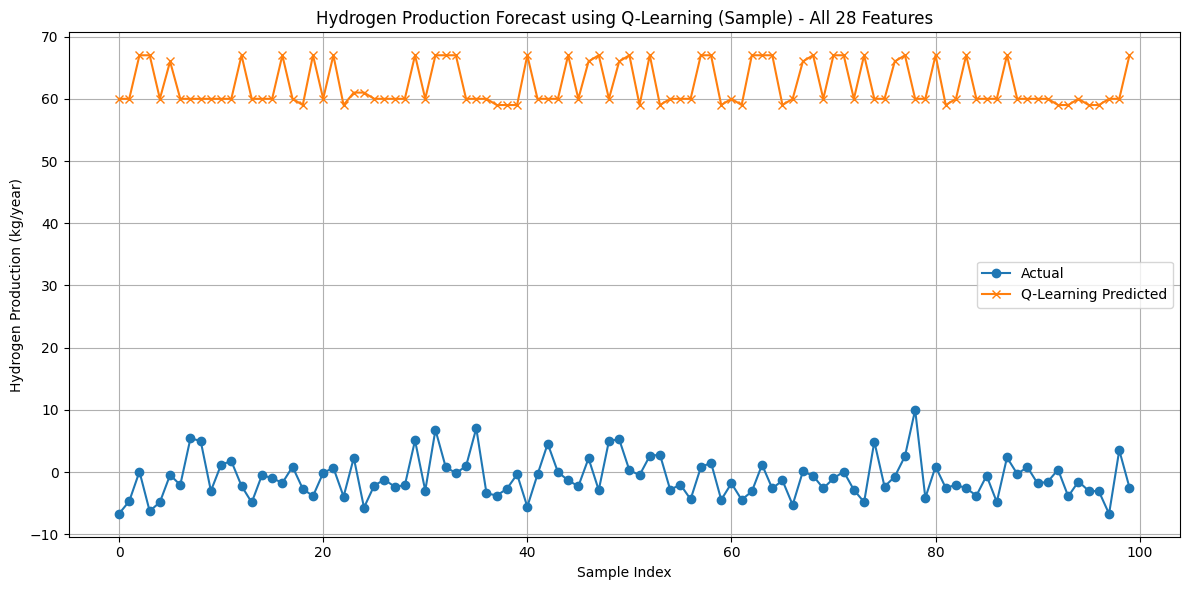

In [30]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load dataset
file_path = "/content/normalized_green_hydrogen_jodhpur_2023.csv"
df = pd.read_csv(file_path)

# Step 2: Select all features and target
selected_features = df.columns.tolist()
# Exclude non-numeric columns, specifically the 'Date' column
if 'Date' in selected_features:
    selected_features.remove('Date')
# Exclude 'Panel_Type' column
if 'Panel_Type' in selected_features:
    selected_features.remove('Panel_Type')
selected_features.remove("Annual_H2_Production")
target = "Annual_H2_Production"

X = df[selected_features].values
y = df[[target]].values.reshape(-1, 1)

# Step 3: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 4: Define a Q-learning compatible environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # Discretized H2 prediction from 56 to 67
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Step 5: Initialize Q-table
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))

# Step 6: Q-learning parameters
episodes = 100
alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # exploration rate

# Step 7: Q-learning training loop
print("Starting Q-learning training...")
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action] if not done else reward
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes} - Total Reward: {total_reward:.2f}")

# Step 8: Evaluate the Q-learning model
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Step 9: Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("\nQ-Learning Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Step 10: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Q-Learning Predicted', marker='x')
plt.title('Hydrogen Production Forecast using Q-Learning (Sample) - All 28 Features')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/year)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Starting Q-learning training...
Episode 100/1000 - Total Reward: -3792.91
Episode 200/1000 - Total Reward: -2998.91
Episode 300/1000 - Total Reward: -2369.38
Episode 400/1000 - Total Reward: -2030.40
Episode 500/1000 - Total Reward: -1902.43
Episode 600/1000 - Total Reward: -1802.70
Episode 700/1000 - Total Reward: -1838.30
Episode 800/1000 - Total Reward: -1964.55
Episode 900/1000 - Total Reward: -1815.66
Episode 1000/1000 - Total Reward: -1894.60

Reinforcement Learning (Q-Learning Agent) Results:
MAE: 0.2519
MSE: 0.0843
R² Score: 0.9779



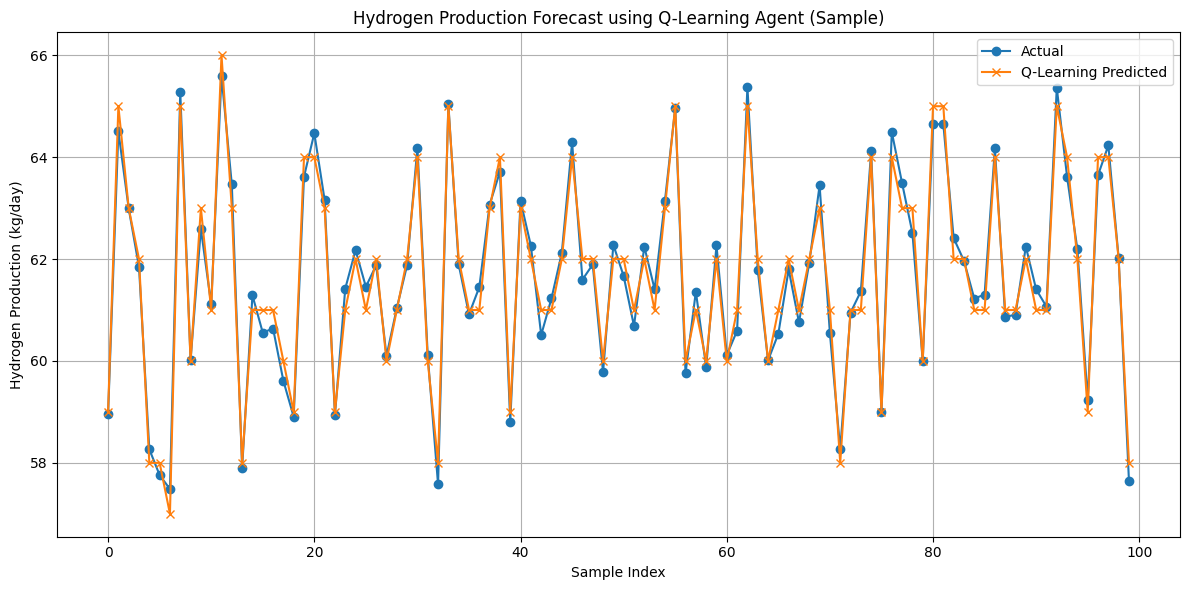

In [ ]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset manually
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Step 2: Verify required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize features and target
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define a Q-learning compatible environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # Discretized hydrogen predictions: 56 to 67 kg/day
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Step 6: Initialize Q-table
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))

# Step 7: Q-learning parameters
episodes = 1000  # Total training episodes
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

# Step 8: Q-learning loop
print("Starting Q-learning training...")
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action] if not done else reward
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes} - Total Reward: {total_reward:.2f}")

# Step 9: Use Q-table to generate predictions
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Step 10: Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("\nReinforcement Learning (Q-Learning Agent) Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Step 11: Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Q-Learning Predicted', marker='x')
plt.title('Hydrogen Production Forecast using Q-Learning Agent (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load dataset
file_path = "/content/normalized_green_hydrogen_jodhpur_2023.csv"
df = pd.read_csv(file_path)

# Step 2: Select all features and target
selected_features = df.columns.tolist()
selected_features.remove("Annual_H2_Production")
target = "Annual_H2_Production"

X = df[selected_features].values
y = df[[target]].values.reshape(-1, 1)

# Step 3: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 4: Define Q-learning compatible environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # Discretized H2 prediction from 56 to 67
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Step 5: Initialize Q-table
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))

# Step 6: Q-learning parameters
episodes = 1000
alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # exploration rate

# Step 7: Q-learning loop
print("Starting Q-learning training...")
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action] if not done else reward
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes} - Total Reward: {total_reward:.2f}")

# Step 8: Evaluate the Q-learning model
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Step 9: Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("\nQ-Learning Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Step 10: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Q-Learning Predicted', marker='x')
plt.title('Hydrogen Production Forecast using Q-Learning (Sample) - All 28 Features')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/year)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: '2023-01-01'

SARSA(RL)

Enter the path to your dataset CSV file: /content/synthetic_green_hydrogen_dataset.zip
Reinforcement Learning (SARSA Agent) Results:
MAE: 4.7082
MSE: 26.0397
R² Score: -5.8237



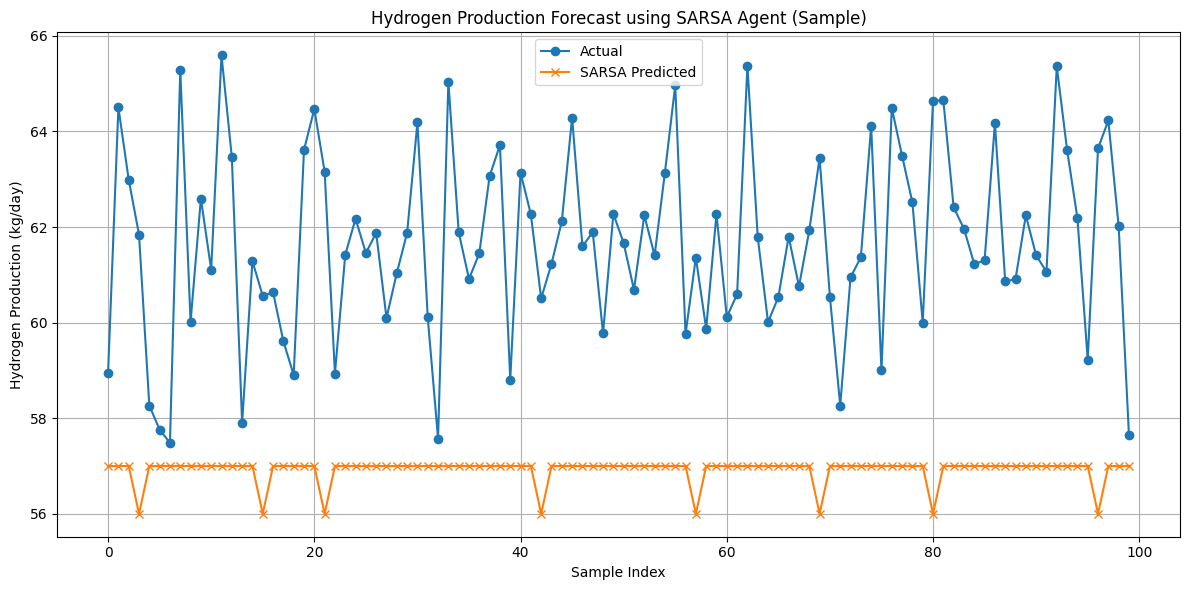

In [ ]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Required columns
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# SARSA-compatible Gym environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # 56 to 67 kg/day
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Initialize SARSA
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))

# SARSA hyperparameters
episodes = 1
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# SARSA training
for episode in range(episodes):
    state = env.reset()
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(q_table[state])

    done = False
    while not done:
        next_state, reward, done, _ = env.step(action)
        if np.random.uniform(0, 1) < epsilon:
            next_action = np.random.randint(0, env.action_space.n)
        else:
            next_action = np.argmax(q_table[next_state])

        td_target = reward + gamma * q_table[next_state][next_action] if not done else reward
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state
        action = next_action

# Prediction using SARSA
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("Reinforcement Learning (SARSA Agent) Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='SARSA Predicted', marker='x')
plt.title('Hydrogen Production Forecast using SARSA Agent (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

DYNA -Q

In [ ]:
import pandas as pd
import numpy as np
import gym
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
file_path = input("Enter the path to your dataset CSV file: ")
df = pd.read_csv(file_path)

# Required columns
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Dyna-Q compatible Gym environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.observation_space = gym.spaces.Discrete(len(self.X))
        self.action_space = gym.spaces.Discrete(12)  # 56 to 67 kg/day
        self.action_values = np.linspace(56, 67, 12)

    def reset(self):
        self.index = 0
        return self.index

    def step(self, action):
        predicted = self.action_values[action]
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.index if not done else 0
        return next_state, reward, done, {}

# Initialize environment and Q-table
env = HydrogenForecastEnv(X_scaled, y_scaled)
q_table = np.zeros((len(X_scaled), env.action_space.n))
model = {}  # (state, action): (next_state, reward)

# Dyna-Q parameters
episodes = 1
alpha = 0.1
gamma = 0.95
epsilon = 0.1
planning_steps = 10

# Training with Dyna-Q
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)

        # Q-learning update
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action] if not done else reward
        q_table[state][action] += alpha * (td_target - q_table[state][action])

        # Store model
        model[(state, action)] = (next_state, reward)

        # Planning steps
        for _ in range(planning_steps):
            if model:
                s, a = list(model.keys())[np.random.randint(0, len(model))]
                ns, r = model[(s, a)]
                best_na = np.argmax(q_table[ns])
                target = r + gamma * q_table[ns][best_na] if ns < len(X_scaled) else r
                q_table[s][a] += alpha * (target - q_table[s][a])

        state = next_state

# Prediction using Dyna-Q
env_pred = HydrogenForecastEnv(X_scaled, y_scaled)
state = env_pred.reset()
done = False
preds = []
y_actual = []

while not done:
    action = np.argmax(q_table[state])
    true_val = target_scaler.inverse_transform([[env_pred.y[state]]])[0][0]
    y_actual.append(true_val)
    preds.append(env_pred.action_values[action])
    state, _, done, _ = env_pred.step(action)

# Evaluation
mae = mean_absolute_error(y_actual, preds)
mse = mean_squared_error(y_actual, preds)
r2 = r2_score(y_actual, preds)
print("Reinforcement Learning (Dyna-Q Agent) Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}\n")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Dyna-Q Predicted', marker='x')
plt.title('Hydrogen Production Forecast using Dyna-Q Agent (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install stable_baselines3 gymnasium

A2C(DRL)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 515      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.45    |
|    explained_variance | -0.795   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -32.2    |
|    value_loss         | 227      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 511      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.44    |
|    explained_variance | -0.217   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -26.3    |
|    value_loss      

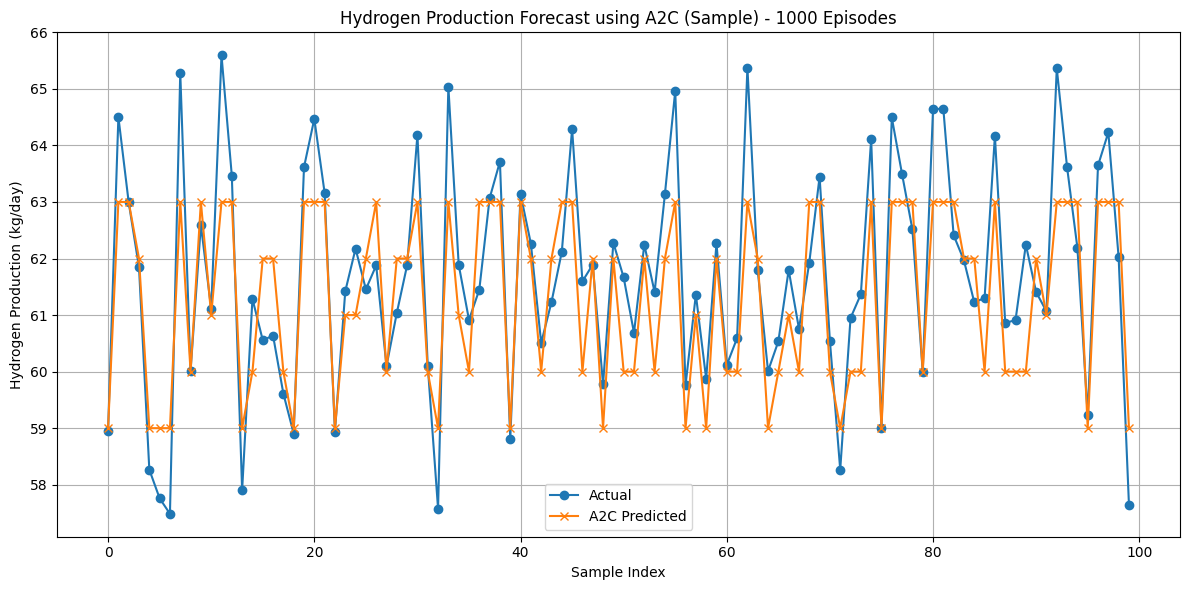

In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Step 1: Load dataset
file_path = "/content/synthetic_green_hydrogen_dataset.zip"
df = pd.read_csv(file_path)

# Step 2: Ensure required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define Gymnasium environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_values = np.linspace(56, 67, 12)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(len(self.action_values))

    def reset(self, seed=None, options=None):
        self.index = 0
        return self.X[self.index], {}

    def step(self, action):
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        predicted = self.action_values[action]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        return next_obs, reward, done, False, {}

# Step 6: A2C Training and Evaluation (1000 episodes)
env = DummyVecEnv([lambda: HydrogenForecastEnv(X_scaled, y_scaled)])
model = A2C("MlpPolicy", env, verbose=1)

episodes = 10
model.learn(total_timesteps=len(X_scaled) * episodes)

# Evaluation
env_eval = HydrogenForecastEnv(X_scaled, y_scaled)
obs, _ = env_eval.reset()
done = False
preds_a2c = []
y_actual = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    true_val = target_scaler.inverse_transform([[env_eval.y[env_eval.index]]])[0][0]
    y_actual.append(true_val)
    preds_a2c.append(env_eval.action_values[action])
    obs, _, done, _, _ = env_eval.step(action)

mae_a2c = mean_absolute_error(y_actual, preds_a2c)
mse_a2c = mean_squared_error(y_actual, preds_a2c)
r2_a2c = r2_score(y_actual, preds_a2c)
print("A2C Results:")
print(f"MAE: {mae_a2c:.4f}")
print(f"MSE: {mse_a2c:.4f}")
print(f"R² Score: {r2_a2c:.4f}\n")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds_a2c[:100], label='A2C Predicted', marker='x')
plt.title('Hydrogen Production Forecast using A2C (Sample) - 1000 Episodes')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

PPO(DRL)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 716  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 643         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012030005 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | -0.0191     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.32e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 2.99e+03    |
-----------------------------------------
-----------------

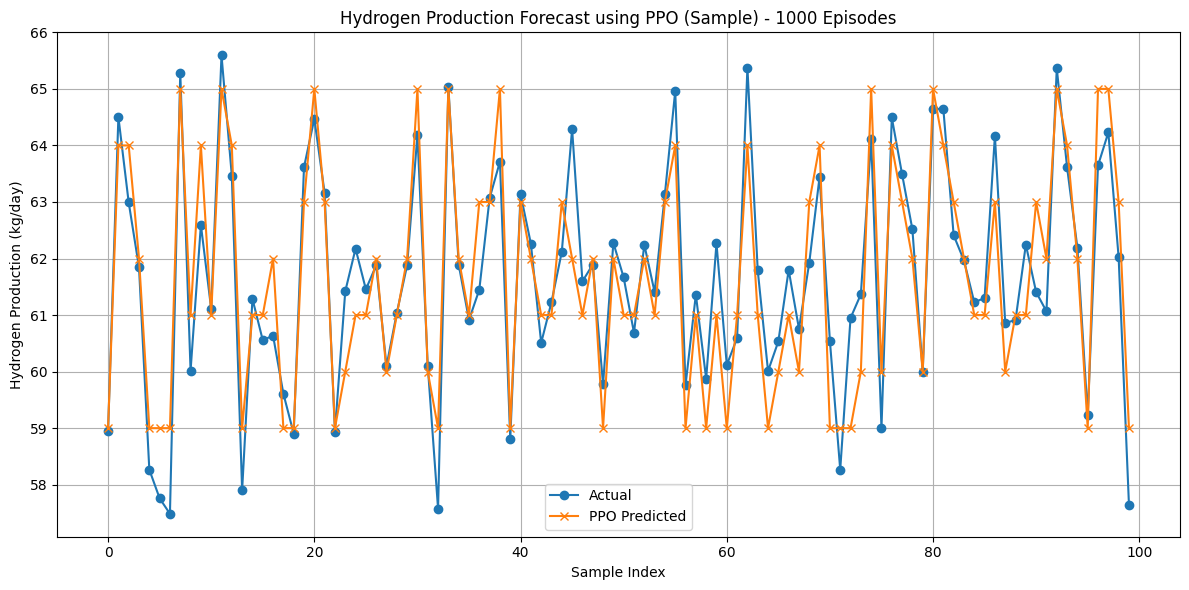

In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Step 1: Load dataset
file_path = "/content/synthetic_green_hydrogen_dataset.zip"
df = pd.read_csv(file_path)

# Step 2: Ensure required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define Gymnasium environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_values = np.linspace(56, 67, 12)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(len(self.action_values))

    def reset(self, seed=None, options=None):
        self.index = 0
        return self.X[self.index], {}

    def step(self, action):
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        predicted = self.action_values[action]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        return next_obs, reward, done, False, {}

# Step 6: PPO Training and Evaluation (1000 episodes)
env = DummyVecEnv([lambda: HydrogenForecastEnv(X_scaled, y_scaled)])
model = PPO("MlpPolicy", env, verbose=1)

episodes = 10
model.learn(total_timesteps=len(X_scaled) * episodes)

# Evaluation
env_eval = HydrogenForecastEnv(X_scaled, y_scaled)
obs, _ = env_eval.reset()
done = False
preds_ppo = []
y_actual = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    true_val = target_scaler.inverse_transform([[env_eval.y[env_eval.index]]])[0][0]
    y_actual.append(true_val)
    preds_ppo.append(env_eval.action_values[action])
    obs, _, done, _, _ = env_eval.step(action)

mae_ppo = mean_absolute_error(y_actual, preds_ppo)
mse_ppo = mean_squared_error(y_actual, preds_ppo)
r2_ppo = r2_score(y_actual, preds_ppo)
print("PPO Results:")
print(f"MAE: {mae_ppo:.4f}")
print(f"MSE: {mse_ppo:.4f}")
print(f"R² Score: {r2_ppo:.4f}\n")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds_ppo[:100], label='PPO Predicted', marker='x')
plt.title('Hydrogen Production Forecast using PPO (Sample) - 1000 Episodes')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

DQN(DRL)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 725      |
|    time_elapsed     | 18       |
|    total_timesteps  | 13152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 3262     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 711      |
|    time_elapsed     | 36       |
|    total_timesteps  | 26304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.128    |
|    n_updates        | 6550     |
----------------------------------
DQN Results:
MAE: 0.6032
MSE: 0.5745
R² Score: 0.8495



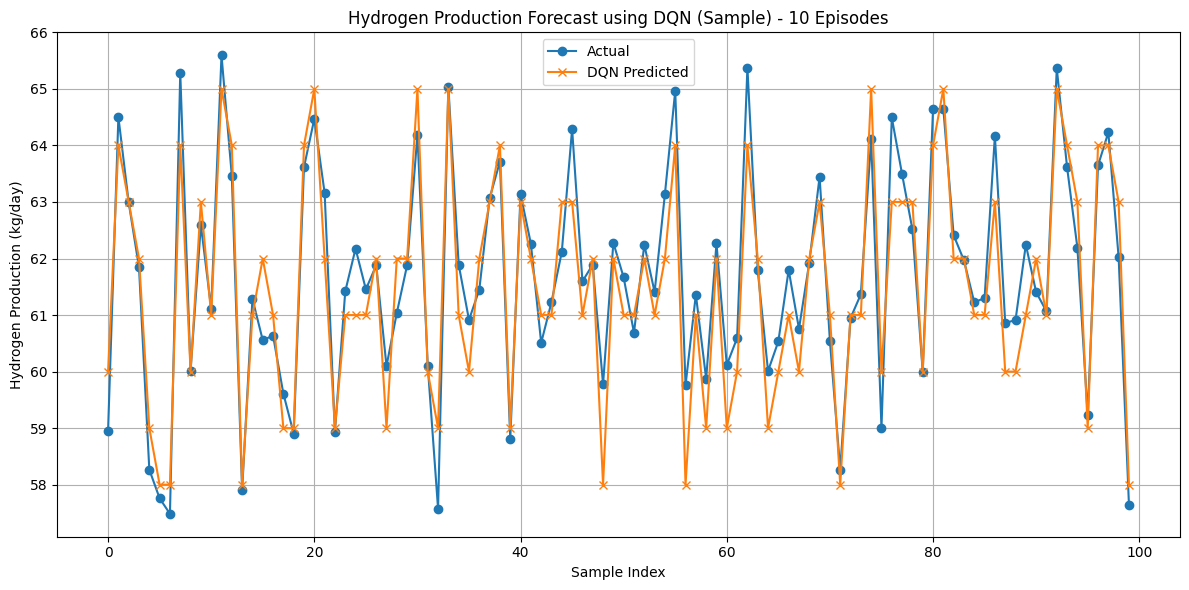

In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# Step 1: Load dataset
file_path = "/content/synthetic_green_hydrogen_dataset.zip"
df = pd.read_csv(file_path)

# Step 2: Ensure required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define Gymnasium environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_values = np.linspace(56, 67, 12)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(len(self.action_values))

    def reset(self, seed=None, options=None):
        self.index = 0
        return self.X[self.index], {}

    def step(self, action):
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        predicted = self.action_values[action]
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        return next_obs, reward, done, False, {}

# Step 6: DQN Training and Evaluation
env = DummyVecEnv([lambda: HydrogenForecastEnv(X_scaled, y_scaled)])
model = DQN("MlpPolicy", env, verbose=1)

episodes = 10
model.learn(total_timesteps=len(X_scaled) * episodes)

# Evaluation
env_eval = HydrogenForecastEnv(X_scaled, y_scaled)
obs, _ = env_eval.reset()
done = False
preds_dqn = []
y_actual = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    true_val = target_scaler.inverse_transform([[env_eval.y[env_eval.index]]])[0][0]
    y_actual.append(true_val)
    preds_dqn.append(env_eval.action_values[action])
    obs, _, done, _, _ = env_eval.step(action)

mae_dqn = mean_absolute_error(y_actual, preds_dqn)
mse_dqn = mean_squared_error(y_actual, preds_dqn)
r2_dqn = r2_score(y_actual, preds_dqn)
print("DQN Results:")
print(f"MAE: {mae_dqn:.4f}")
print(f"MSE: {mse_dqn:.4f}")
print(f"R² Score: {r2_dqn:.4f}\n")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds_dqn[:100], label='DQN Predicted', marker='x')
plt.title('Hydrogen Production Forecast using DQN (Sample) - 10 Episodes')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


SAC DRL

In [1]:
!pip install stable_baselines3 gymnasium

Using cuda device

Starting SAC training for 10 episodes (Total timesteps: 32880)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 159      |
|    total_timesteps | 13152    |
| train/             |          |
|    actor_loss      | 56       |
|    critic_loss     | 0.509    |
|    ent_coef        | 0.234    |
|    ent_coef_loss   | 0.0336   |
|    learning_rate   | 0.0003   |
|    n_updates       | 13051    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 82       |
|    time_elapsed    | 318      |
|    total_timesteps | 26304    |
| train/             |          |
|    actor_loss      | 76.1     |
|    critic_loss     | 0.447    |
|    ent_coef        | 0.242    |
|    ent_coef_loss   | -0.0673  |
|    learning_rate   | 0.0003   |
|    n_updates       | 26203    |

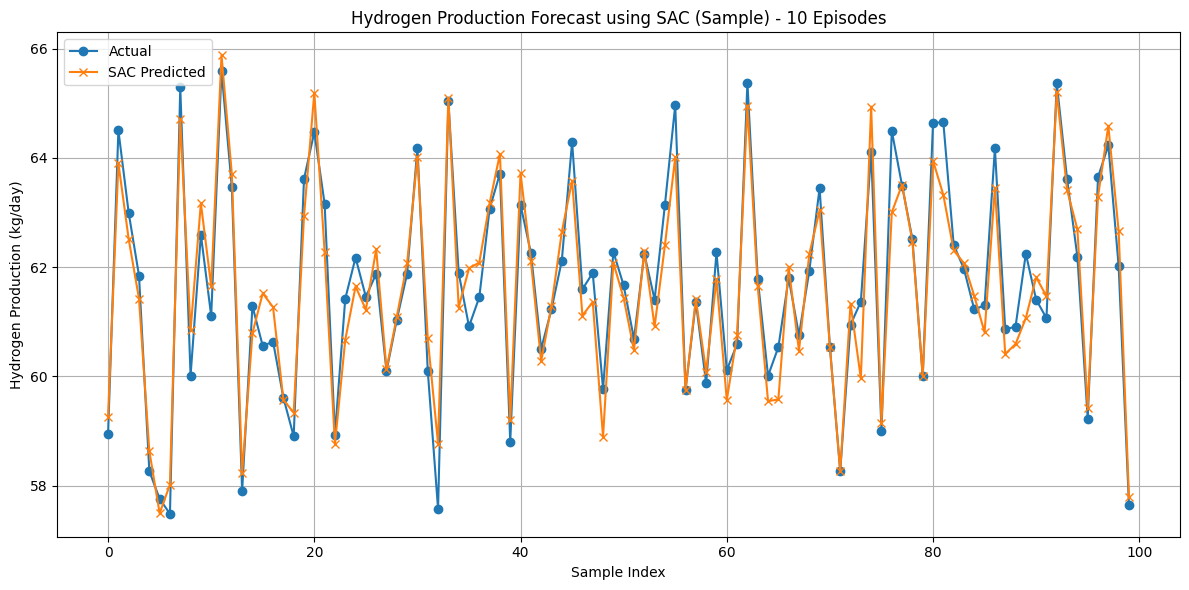

In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv

# Step 1: Load dataset
file_path = "/content/synthetic_green_hydrogen_dataset.zip"
df = pd.read_csv(file_path)

# Step 2: Ensure required columns are present
required_columns = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio',
    'Daily_Hydrogen_Production'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Step 3: Select features and target
selected_features = [
    'Solar_Irradiance_Horizontal', 'Ambient_Temperature',
    'Voltage', 'Current', 'Power_Output', 'Performance_Ratio'
]
target = 'Daily_Hydrogen_Production'

X = df[selected_features].values
y = df[target].values.reshape(-1, 1)

# Step 4: Normalize
feature_scaler = MinMaxScaler(feature_range=(-10, 10))
target_scaler = MinMaxScaler(feature_range=(56, 67))
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

# Step 5: Define Gymnasium environment
class HydrogenForecastEnv(gym.Env):
    def __init__(self, X, y):
        super(HydrogenForecastEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_low = 56.0
        self.action_high = 67.0
        self.observation_space = spaces.Box(low=-10, high=10, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([self.action_low], dtype=np.float32), high=np.array([self.action_high], dtype=np.float32), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.index = 0
        return self.X[self.index], {}

    def step(self, action):
        true_val = target_scaler.inverse_transform([[self.y[self.index]]])[0][0]
        predicted = np.clip(action[0], self.action_low, self.action_high)
        reward = -abs(predicted - true_val)
        self.index += 1
        done = self.index >= len(self.X)
        next_obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        return next_obs, reward, done, False, {}

# Step 6: SAC Training and Evaluation
env = DummyVecEnv([lambda: HydrogenForecastEnv(X_scaled, y_scaled)])
model = SAC("MlpPolicy", env, verbose=1)

episodes = 1000
total_timesteps = len(X_scaled) * episodes
print(f"\nStarting SAC training for {episodes} episodes (Total timesteps: {total_timesteps})\n")
model.learn(total_timesteps=total_timesteps)

# Evaluation
env_eval = HydrogenForecastEnv(X_scaled, y_scaled)
obs, _ = env_eval.reset()
done = False
preds_sac = []
y_actual = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    true_val = target_scaler.inverse_transform([[env_eval.y[env_eval.index]]])[0][0]
    y_actual.append(true_val)
    preds_sac.append(np.clip(action[0], 56, 67))
    obs, _, done, _, _ = env_eval.step(action)

mae_sac = mean_absolute_error(y_actual, preds_sac)
mse_sac = mean_squared_error(y_actual, preds_sac)
r2_sac = r2_score(y_actual, preds_sac)
print("SAC Results:")
print(f"MAE: {mae_sac:.4f}")
print(f"MSE: {mse_sac:.4f}")
print(f"R² Score: {r2_sac:.4f}\n")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual', marker='o')
plt.plot(preds_sac[:100], label='SAC Predicted', marker='x')
plt.title('Hydrogen Production Forecast using SAC (Sample) - 10 Episodes')
plt.xlabel('Sample Index')
plt.ylabel('Hydrogen Production (kg/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
